In [82]:
%matplotlib inline

import arcpy
import os, shutil
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from scipy import stats


#workingDir = "Z:\Auxiliary\Project_Folders\CS_Sandbox\\NCALM\\bulking\\v2\\plots_run0"
#arcpy.env.workspace=workingDir
arcpy.env.overwriteOutput = 1


In [83]:
# Set up functions

# Remove outlier function
def rmout(data, nstd):
    #s, outInd = rmout(data,nstd)
    s = np.std(data)
    outInd = (data<data.mean()+nstd*data.std()) & (data>data.mean()-nstd*data.std())
    return s, outInd

In [84]:
# Bring in dataframe from previous notebook
# Bring in data
flds = ["subpoly", "net_total", "eros", "dep", "dx", "elev_mean", "elev_std"]
dff = pd.DataFrame(arcpy.da.TableToNumPyArray('analysis_polys_trunk', flds))
dff = dff.sort_values(by=['subpoly'])

# Elevation mean and std was done on pre-event topography

lines = 'Full_DF_Vector\df_lines'
where = """init_id LIKE '%_T' """
arcpy.management.SelectLayerByAttribute(lines, "NEW_SELECTION", where, None)
flds2 = ["init_id", "length_m"]
dfl = pd.DataFrame(arcpy.da.TableToNumPyArray(lines, flds2))
dfl["df_id"] = [d[:-2] for d in dfl.init_id]

# Bring in df_polys to get quality control binary value
flds3 = ["df_id", "qc_bin","full_track"]
dfqc = pd.DataFrame(arcpy.da.TableToNumPyArray('Full_DF_Vector\df_polys_trunk', flds3))

dff

,subpoly,net_total,eros,dep,dx,elev_mean,elev_std
1195,G01_T_010,-181.824997,-237.048004,55.223801,10.0,480.542999,4.172580
1200,G01_T_020,-108.634003,-126.880997,18.246599,20.0,471.039001,2.738300
1204,G01_T_030,7.597410,-5.643270,13.240700,30.0,464.589996,1.675540
1209,G01_T_040,-27.385099,-28.626900,1.241880,40.0,459.325012,1.697140
1215,G01_T_050,-21.024000,-33.891899,12.867900,50.0,454.110992,1.435260
...,...,...,...,...,...,...,...
1186,P24_T_250,50.032700,-28.726700,78.759399,250.0,577.708984,1.186630
1182,P24_T_260,8.448730,-17.820499,26.269199,260.0,574.656006,1.305560
1179,P24_T_270,56.061798,-9.805970,65.867798,270.0,570.482971,2.215650
1176,P24_T_280,179.559006,-4.342530,183.901001,280.0,566.531982,1.146170


In [85]:
# Add additional info

# Debris flow ID
dff["df_id"] = [d[:3] for d in dff.subpoly]
# Total Length (m) to normalize distance downslope
dff["tl"] = 0
# Maximum amt of mobilized material
dff["maxV"] = 0
# Change detectinon cumulative sum
dff["cdcs"] = 0

for d in dff.df_id.unique():
    dff.loc[dff.df_id == d, 'tl'] = dfl[dfl.df_id==d].length_m.values[0]
    dff.loc[dff.df_id == d, 'cdcs'] = dff[dff.df_id==d].net_total.cumsum()
    dff.loc[dff.df_id == d, 'maxV'] = -1*dff[dff.df_id==d].cdcs.min()

dff["dxnorm"] = dff.dx/dff.tl
dff['cdnorm'] = dff.cdcs/dff.maxV

# Calculate slope
ddx = dff.dx.diff()
dff["slope_deg"] = np.abs(np.rad2deg(np.arctan((dff.elev_mean - dff.elev_mean.shift(-1)) / ddx.shift(-1))))
# Remove final value for each debris flow
#for d in dff.df_id.unique():
    #nx = np.max(dff[dff.df_id == d].dx)
    #nx = dff[(dff.df_id=="P23") & (dff.dx==340)].index
    #dff.loc[nx[0], 'slope_deg'] = np.nan
# Stream power index:
#outRas = Raster(r"GP_el_3m_facc_area.tif") * Tan(Float(Raster(r"GP_sl_3m.tif") * 3.141593 / 180))

# Export to CSV
#dff.to_csv('e:\scratch\df_data.csv')

dff

,subpoly,net_total,eros,dep,dx,elev_mean,elev_std,df_id,tl,maxV,cdcs,dxnorm,cdnorm,slope_deg
1195,G01_T_010,-181.824997,-237.048004,55.223801,10.0,480.542999,4.172580,G01,99.472198,353.600525,-181.824997,0.100531,-0.514210,43.543232
1200,G01_T_020,-108.634003,-126.880997,18.246599,20.0,471.039001,2.738300,G01,99.472198,353.600525,-290.458984,0.201061,-0.821433,32.817989
1204,G01_T_030,7.597410,-5.643270,13.240700,30.0,464.589996,1.675540,G01,99.472198,353.600525,-282.861572,0.301592,-0.799947,27.766733
1209,G01_T_040,-27.385099,-28.626900,1.241880,40.0,459.325012,1.697140,G01,99.472198,353.600525,-310.246674,0.402122,-0.877393,27.537626
1215,G01_T_050,-21.024000,-33.891899,12.867900,50.0,454.110992,1.435260,G01,99.472198,353.600525,-331.270660,0.502653,-0.936850,24.891222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,P24_T_250,50.032700,-28.726700,78.759399,250.0,577.708984,1.186630,P24,283.195007,1616.525879,-1321.451416,0.882784,-0.817464,16.977318
1182,P24_T_260,8.448730,-17.820499,26.269199,260.0,574.656006,1.305560,P24,283.195007,1616.525879,-1313.002686,0.918095,-0.812237,22.650946
1179,P24_T_270,56.061798,-9.805970,65.867798,270.0,570.482971,2.215650,P24,283.195007,1616.525879,-1256.940918,0.953407,-0.777557,21.558918
1176,P24_T_280,179.559006,-4.342530,183.901001,280.0,566.531982,1.146170,P24,283.195007,1616.525879,-1077.381958,0.988718,-0.666480,27.474396


In [87]:
# Set up plotting space
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['lines.markersize'] = 3
paperWidth = 6
paperHeight = 4
mpl.rcParams['figure.figsize'] = [paperWidth, paperHeight]

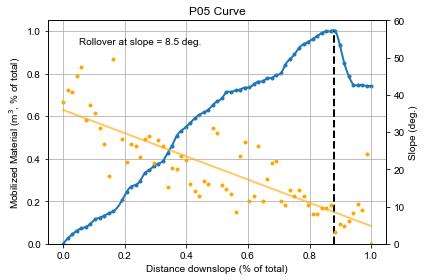

In [88]:
# Plot up individual curves - Volume vs. distance

maxSmat = np.empty(0)

# for d in dff.df_id.unique():
for d in dff[(dff.df_id=="P05")].df_id.unique():
    if (dfqc[dfqc.df_id==d].qc_bin == 1).bool():
        fig, (ax1) = plt.subplots(1, 1)

        # Dummy zero
        z = pd.DataFrame([[np.nan] * len(dff.columns)], columns=dff.columns)

        # Get x values, distance or normalized distance
        xdn = dff[dff.df_id==d].sort_values(by='dx').copy()
        x = z.append(xdn, ignore_index=True)
        x.loc[0,'dxnorm'] = 0
        x = x.dxnorm

        # Get y values, normalized material
        ydn = -1*dff[dff.df_id==d].sort_values(by='dx').copy()
        y = z.append(ydn, ignore_index=True)
        y.loc[0,'cdnorm'] = 0
        y = y.cdnorm

        # Get y values, slope for each subpoly
        y2 = np.append(dff[dff.df_id==d].slope_deg, np.array(0))     
        x3 = x[np.isnan(y2) == 0]
        y3 = y2[np.isnan(y2) == 0]
        yr = ax1.twinx()

        # Scatter plots
        ax1.scatter(x, y)
        yr.scatter(x3.tolist(), y3, c='orange')

        # Best fit lines    
        xnew = np.linspace(x.min(), x.max(), num=200, endpoint=True)
        f2 = interp1d(x, y, kind='cubic')
        ax1.plot(xnew, f2(xnew), linewidth='2', label='DF {0}'.format(d))

        #xnew3 = np.linspace(x3.min(), x3.max(), num=20, endpoint=True)
        #f3 = interp1d(x3, y3, kind='linear')
        #yr.plot(xnew3, f3(xnew3), linewidth='2', c='orange', label='DF {0}'.format(d))

        m, b = np.polyfit(x3, y3, 1)
        yp = m*np.sort(x3) + b
        yr.plot(np.sort(x3), yp, c='orange', linewidth=2, alpha=0.6)
        #yr.plot(np.sort(x3), yp+(2*np.std(y3)), 'o--', alpha=0.3)
        #yr.plot(np.sort(x3), yp-(2*np.std(y3)), 'o--', alpha=0.3)

        # Plot vertical line at maximum
        i = f2(xnew) == f2(xnew).max()
        maxX = xnew[i==True]
        #maxS = f3(maxX)
        maxS = m*maxX + b
        ax1.vlines(maxX, 0, 1, 'k', linestyles = 'dashed', lw=2)
        maxSmat = np.append(maxSmat, maxS)
        ax1.text(0.05, 0.94, 'Rollover at slope = {0} deg.'.format(round(maxS[0],1)))

        # Set plot params
        ax1.set_ylabel('Mobilized Material (m$^3$, % of total)')
        ax1.set_xlabel('Distance downslope (% of total)')
        yr.set_ylabel('Slope (deg.)')

        #ax1.set_xlim([0, 1])
        ax1.set_ylim([0, 1.05])
        yr.set_ylim([0, 60])
        ax1.grid(1)
        ax1.set_title('{0} Curve'.format(d))
        #ax1.set_yscale('log')
        #plt.gca().invert_xaxis()
        #ax1.legend()

        plt.tight_layout()

        #fig.savefig('Z:\\Auxiliary\\Project_Folders\CS_Sandbox\\NCALM\\graphics\\curves\\20210527_trunkcurves\\{0}_curve.jpg'.format(d), dpi=1000)

        plt.show()
        plt.close()

        
# Save slope rollover to pickle
#f = 'Z:\\Auxiliary\\Project_Folders\CS_Sandbox\\NCALM\\pickles\\maxSmat'
#np.save(f, maxSmat, 1)

In [125]:
# Plot up individual curves - Entrainment rates

for d in dff.df_id.unique():
#for d in dff[(dff.df_id=="G28")].df_id.unique():
    if (dfqc[dfqc.df_id==d].qc_bin == 1).bool():

        fig, (ax1) = plt.subplots(1, 1)

        # Dummy zero
        z = pd.DataFrame([[np.nan] * len(dff.columns)], columns=dff.columns)

        # Get x values, distance or normalized distance
        xdn = dff[dff.df_id==d].sort_values(by='dx').copy()
        x = z.append(xdn, ignore_index=True)
        x.loc[0,'dxnorm'] = 0
        x = x.dxnorm

        # Get y values, normalized material
        ydn = -1*dff[dff.df_id==d].sort_values(by='dx').copy()
        y = z.append(ydn, ignore_index=True)
        y.loc[0,'cdcs'] = 0
        y.loc[0, 'dx'] = 0
        y = -1*y.cdcs/y.dx
        y[np.isnan(y)] = 0

        # Get y values, slope for each subpoly
        y2 = np.append(dff[dff.df_id==d].slope_deg, np.array(0))     
        x3 = x[np.isnan(y2) == 0]
        y3 = y2[np.isnan(y2) == 0]
        yr = ax1.twinx()

        # Scatter plots
        ax1.scatter(x, y)
        yr.scatter(x3.tolist(), y3, c='orange')

        # Best fit lines    
        xnew = np.linspace(x[x>0].min(), x.max(), num=200, endpoint=True)
        f2 = interp1d(x, y, kind='cubic')
        ax1.plot(xnew, f2(xnew), linewidth='2', label='DF {0}'.format(d))

        m, b = np.polyfit(x3, y3, 1)
        yp = m*np.sort(x3) + b
        yr.plot(np.sort(x3), yp, c='orange', linewidth=2, alpha=0.6)

        # Set plot params
        ax1.set_ylabel('Entrainment Rate (m$^3$ / m [trunk] )')
        ax1.set_xlabel('Distance downslope (% of total)')
        yr.set_ylabel('Slope (deg.)')

        #ax1.set_xlim([0, 1])
        #ax1.set_ylim([0, 1.05])
        yr.set_ylim([0, 60])
        ax1.grid(1)
        ax1.set_title('{0} Curve'.format(d))
        #ax1.set_yscale('log')
        #plt.gca().invert_yaxis()
        #ax1.legend()

        plt.tight_layout()

        #fig.savefig('Z:\\Auxiliary\\Project_Folders\CS_Sandbox\\NCALM\\graphics\\curves\\20210527_trunkratecurves\\{0}_curve.jpg'.format(d), dpi=1000)

        #plt.show()
        plt.close()